# BerkeleyHaas Case Series: Rocket Fuel: Measuring the Effectiveness of Online Advertising
Questions taken from the case study

## 1) Was the advertising campaign effective? Did additional consumers convert as a result of the ad campaign?

In [1]:
import pandas as pd

In [2]:
# import data
df = pd.read_csv('2017_9_rocketfuel_5896.csv')
df.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,1069124,1,0,130,1,20
1,1119715,1,0,93,2,22
2,1144181,1,0,21,2,18
3,1435133,1,0,355,2,10
4,1015700,1,0,276,5,14


In [3]:
df.describe()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
count,5.881010e+05,588101.000000,588101.000000,588101.000000,588101.000000,588101.000000
mean,1.310692e+06,0.960000,0.025239,24.820876,4.025533,14.469061
std,2.022260e+05,0.195959,0.156850,43.715181,2.004019,4.834634
min,9.000000e+05,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.143190e+06,1.000000,0.000000,4.000000,2.000000,11.000000
50%,1.313725e+06,1.000000,0.000000,13.000000,4.000000,14.000000
75%,1.484088e+06,1.000000,0.000000,27.000000,6.000000,18.000000
max,1.654483e+06,1.000000,1.000000,2065.000000,7.000000,23.000000


In [4]:
# number of users in control group
control = df[df['test'] == 0].converted.value_counts()

In [5]:
control_conversion = control[1] / (control[0] + control[1])
control_conversion

0.01785410644448223

In [6]:
test = df[df['test'] == 1].converted.value_counts()
test

0    550154
1     14423
Name: converted, dtype: int64

In [7]:
test_conversion = test[1] / (test[0] + test[1])
test_conversion

0.025546559636683747

In [8]:
# import stats package for z-test to see if the proportions are dissimilar
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import math

In [9]:
df.groupby('test')['converted'].value_counts()

test  converted
0     0             23104
      1               420
1     0            550154
      1             14423
Name: converted, dtype: int64

In [10]:
n_conv = np.array([control[1], test[1]])
n_conv

array([  420, 14423], dtype=int64)

In [11]:
n_rows = np.array([df.test.value_counts()[0], df.test.value_counts()[1]])
n_rows

array([ 23524, 564577], dtype=int64)

### Here, we feed the arrays into the z-test function to get the z-score and associated p-value

In [12]:
z, p = proportions_ztest(count=n_conv, nobs=n_rows, alternative='smaller')
z, p

(-7.3700781265454145, 8.526403580779863e-14)

### Looks like the z-score is pretty large and the p-value is very small. We can safely say that advertizing does have a positive effect on conversions. Let's see how big the effect is below

### Let's find out what the 99% CI is for the difference showing ads makes

In [13]:
n1 = n_rows[1]
n2 = n_rows[0]
p1 = test_conversion
p2 = control_conversion
mu = p1-p2
variance = p1*(1-p1)/n1 + p2*(1-p2)/n2
sigma = math.sqrt(variance)

In [14]:
print(f'The 99% CI of the difference advertising makes is: [{np.round(p1-p2 - np.sqrt(variance) * norm.ppf(0.995), 3)},{np.round(p1-p2 + np.sqrt(variance) * norm.ppf(0.995), 3)}]')

The 99% CI of the difference advertising makes is: [0.005,0.01]


## 2) Profitability

### a) How much more money did TaskaBella make by running the campaign (excluding advertising costs)?
Extra made from campaing is the extra sales over the number of treatment users. If we assume the control group is the baseline, then we can measure extra sales as the difference in proportions * number of treatment users * marginal profit

In [15]:
ad_diff = test_conversion - control_conversion
test_group = df.test.sum()
conversion_rev = 40
marginal_revenue = ad_diff * test_group * conversion_rev

In [16]:
print('Extra Revenue Generated from ad campaign: 'f'${marginal_revenue:,.2f}')

Extra Revenue Generated from ad campaign: $173,719.29


### b) What was the cost of the campaign?
Cost of campaign was $9 CPM or 9 * total impressions / 1000

In [17]:
total_cost = df.tot_impr.sum() * 9 / 1000
print('Cost of Campaign: 'f'${total_cost:,.2f}')

Cost of Campaign: $131,374.64


### c) Calculate the ROI of the campaign. Was the campaign profitable?
ROI = Total Return - Cost / Cost

In [18]:
ROI = (marginal_revenue - total_cost)/total_cost
print('ROI: 'f'{ROI:.2%}')

ROI: 32.23%


### d) What was the opportunity cost of including a control group; how much more could have TaskaBella made with a smaller control group or not having a control group at all?
The lost extra sales from the control group * conversion revenue

In [19]:
control_group = control.sum()
opp_cost = ad_diff * control_group * conversion_rev

In [20]:
print('Opportunity Cost: 'f'${opp_cost:,.2f}')

Opportunity Cost: $7,238.29


## 3) How did the number of impressions seen by each user influence the effectiveness of advertising?

In [21]:
# we'll be doing some charting so let's get the visual pacakages imported
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_palette('Dark2')

[(0.0, 300.0)]

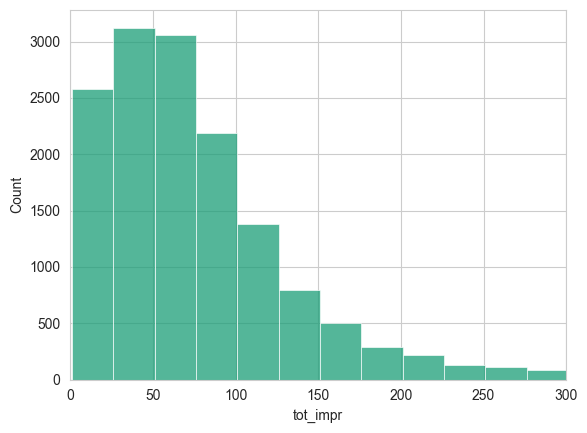

In [22]:
# taking a look at how the data is distributed, we see that the majority of cases are under 100 total impressions. We'll break the 'bins' into 25 viewing increments
g=sns.histplot(data=df[df.converted == 1], x='tot_impr', binwidth=25)
g.set(xlim=(0,300)) #uncomment to zoom in

In [23]:
df['impr_range'] = ['251+' if x >= 251 else '226-250' if x >= 226 else
                    '201-225' if x >= 201 else
                    '176-200' if x >= 176 else '151-175' if x >= 151 else 
                    '126-150' if x >= 126 else '101-125' if x>= 101 else
                    '76-100' if x >= 76 else '51-75' if x >= 51 else
                    '26-50' if x >= 26 else '1-25' for x in df.tot_impr]

In [24]:
impr_range_val = ['1-25','26-50','51-75','76-100','101-125','126-150','151-175','176-200','201-225','226-250','251+']

In [25]:
df.impr_range = pd.Categorical(df.impr_range, categories=impr_range_val, ordered=True)

In [26]:
# make a copy of the dataframe to manipulate for this analysis
df2 = df
# change 1s and 0s to text for legibility
df2.test = ['test' if x == 1 else 'control' for x in df2.test]
df2=df2.rename(columns = {'test':'group'})
df2


,user_id,group,converted,tot_impr,mode_impr_day,mode_impr_hour,impr_range
0,1069124,test,0,130,1,20,126-150
1,1119715,test,0,93,2,22,76-100
2,1144181,test,0,21,2,18,1-25
3,1435133,test,0,355,2,10,251+
4,1015700,test,0,276,5,14,251+
...,...,...,...,...,...,...,...
588096,1278437,test,0,1,2,23,1-25
588097,1327975,test,0,1,2,23,1-25
588098,1038442,test,0,3,2,23,1-25
588099,1496395,test,0,1,2,23,1-25


In [27]:
df3a = df2.groupby(['impr_range','group'])['user_id'].count().to_frame()
df3b = df2.groupby(['impr_range','group'])['converted'].sum().to_frame()

In [28]:
df3 = df3a.merge(df3b, on=['impr_range','group'])
df3.columns = ['user_count', 'converted']
df3['conversion_rate'] = df3.converted / df3.user_count *100
df3

user_count  converted  conversion_rate
impr_range group                                          
1-25       control       17388        106         0.609616
           test         412634       2472         0.599078
26-50      control        3273         87         2.658112
           test          85740       3037         3.542104
51-75      control        1256         66         5.254777
           test          30078       2988         9.934171
76-100     control         597         41         6.867672
           test          14071       2147        15.258333
101-125    control         331         31         9.365559
           test           7471       1350        18.069870
126-150    control         202         26        12.871287
           test           4383        773        17.636322
151-175    control         133         15        11.278195
           test           2708        484        17.872969
176-200    control          86          8         9.302326
           test           1798        285        15.850945
201-225    control          71         12        16.901408
           test           1300        208        16.000000
226-250    control          41          5        12.195122
           test            924        125        13.528139
251+       control         146         23        15.753425
           test           3470        554        15.965418

### a) Create a chart of conversion rates as a function of the number of ads displayed to users. Plot conversion rates for those who were in the control group and for those who were exposed to the ad. Group together number of impressions as necessary to obtain a meaningful plot. (Conversion rate means the percentage of unique users who made a purchase.)

Text(0.5, 1.0, 'Conversion Rate vs Number of Ad Impressions')

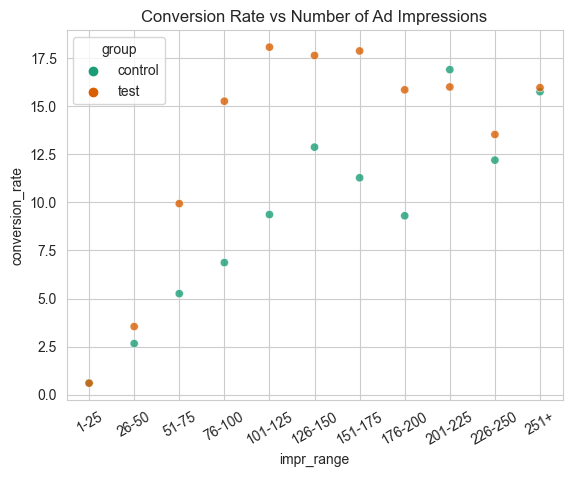

In [29]:
sns.scatterplot(df3, x='impr_range',y='conversion_rate',hue='group',alpha=.8)
plt.xticks(rotation=30)
plt.title('Conversion Rate vs Number of Ad Impressions')

### b) What can you infer from the charts? In what region is advertising most effective?
<font color = 'blue'> As we can see from the scatterplot, there are diminishing returns with more ad impressions, but it takes at least 50 impressions to start making a conversion difference, but by 200 impressions that difference begins to disappear.

### c) What do the above figures imply for the design of the next campaign assuming that consumer response would be similar?
<font color = 'blue'> For the next campaign, given the diminishing returns, the marketing team should limit the number of impressions per user to 200 at most and should focus on increasing the number of distinct users who are exposed to the ad

## 4) How does consumer response to advertising vary on different days of the week and at different times of the day?

In [30]:
# repeat steps above, but for day of week
df4 = df
df4['mode_impr_day'] = ['Monday' if x == 1 else 'Tuesday' if x == 2 else
                        'Wednesday' if x == 3 else 'Thursday' if x == 4 else
                        'Friday' if x == 5 else 'Saturday' if x == 6 else
                        'Sunday' for x in df4.mode_impr_day]
df4.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour,impr_range
0,1069124,test,0,130,Monday,20,126-150
1,1119715,test,0,93,Tuesday,22,76-100
2,1144181,test,0,21,Tuesday,18,1-25
3,1435133,test,0,355,Tuesday,10,251+
4,1015700,test,0,276,Friday,14,251+


In [31]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df4.mode_impr_day = pd.Categorical(df4.mode_impr_day, categories=days, ordered=True)

df4.groupby('mode_impr_day')['converted'].sum()

mode_impr_day
Monday       2857
Tuesday      2312
Wednesday    2018
Thursday     1790
Friday       2057
Saturday     1719
Sunday       2090
Name: converted, dtype: int64

In [32]:
df4=df4.rename(columns={'test':'group'})

df4

,user_id,group,converted,tot_impr,mode_impr_day,mode_impr_hour,impr_range
0,1069124,test,0,130,Monday,20,126-150
1,1119715,test,0,93,Tuesday,22,76-100
2,1144181,test,0,21,Tuesday,18,1-25
3,1435133,test,0,355,Tuesday,10,251+
4,1015700,test,0,276,Friday,14,251+
...,...,...,...,...,...,...,...
588096,1278437,test,0,1,Tuesday,23,1-25
588097,1327975,test,0,1,Tuesday,23,1-25
588098,1038442,test,0,3,Tuesday,23,1-25
588099,1496395,test,0,1,Tuesday,23,1-25


In [33]:
df4a = df4.groupby(['mode_impr_day','group'])['user_id'].count().to_frame()
df4b = df4.groupby(['mode_impr_day','group'])['converted'].sum().to_frame()
df4c = df4a.merge(df4b, on=['mode_impr_day','group'])

df4c.rename(columns={'user_id':'user_count'}, inplace=True)


In [34]:
df4c['conversion_rate'] = df4c.converted / df4c.user_count * 100

df4c

user_count  converted  conversion_rate
mode_impr_day group                                          
Monday        control        3502         79         2.255854
              test          83571       2778         3.324120
Tuesday       control        2907         42         1.444788
              test          74572       2270         3.044038
Wednesday     control        3490         55         1.575931
              test          77418       1963         2.535586
Thursday      control        3905         79         2.023047
              test          79077       1711         2.163714
Friday        control        3803         62         1.630292
              test          88805       1995         2.246495
Saturday      control        2858         40         1.399580
              test          78802       1679         2.130657
Sunday        control        3059         63         2.059497
              test          82332       2027         2.461983

### a) Create a chart with the conversion rates for the control group and the exposed group as a function of the day of week when they were shown the most impressions.

Text(0.5, 1.0, 'Conversion Rate Throughout the Week')

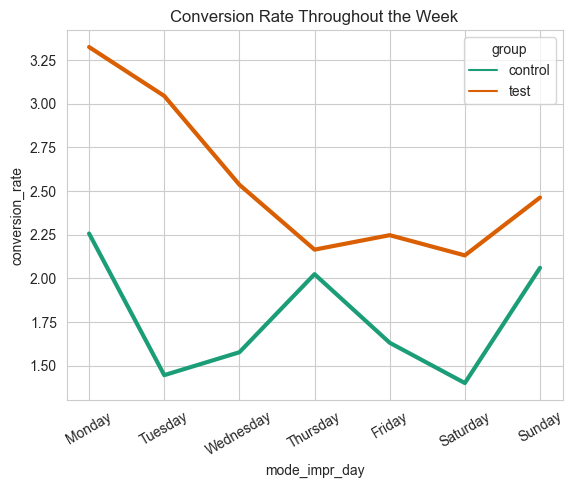

In [35]:
q=sns.lineplot(x='mode_impr_day', y='conversion_rate', hue='group', data=df4c.reset_index(), linewidth=3)
plt.xticks(rotation=30)
plt.title('Conversion Rate Throughout the Week')

In [36]:
df5 = df4[df4['mode_impr_hour'] >= 8]
df5a = df5.groupby(['mode_impr_hour','group'])['user_id'].count().to_frame()
df5b = df5.groupby(['mode_impr_hour','group'])['converted'].sum().to_frame()
df5 = df5a.merge(df5b, on=['mode_impr_hour','group'])

df5.rename(columns={'user_id':'user_count'},inplace=True)

df5['conversion_rate'] = df5.converted / df5.user_count * 100

df5.head()

user_count  converted  conversion_rate
mode_impr_hour group                                          
8              control         659          7         1.062215
               test          16968        337         1.986091
9              control        1202         13         1.081531
               test          29802        582         1.952889
10             control        1485         20         1.346801

### b) Create the same chart for hours within a day (excluding the period between midnight and 8 a.m.).

Text(0.5, 1.0, 'Conversion Rate Throughout the Day (8am to midnight)')

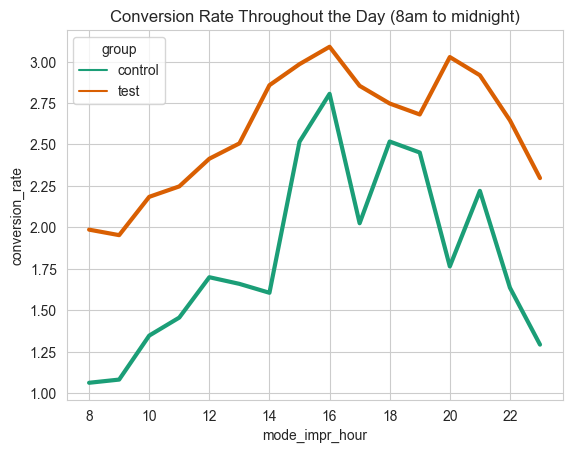

In [37]:
q=sns.lineplot(x='mode_impr_hour', y='conversion_rate', hue='group', data=df5.reset_index(),linewidth=3)

plt.title('Conversion Rate Throughout the Day (8am to midnight)')

### c) What days/hours is advertising most/least effective?
Advertisments are most effective on Monday and Tuesday (or, perhaps users see a critical mass of the ads over the weekend and finally decide to make the purchase on Monday or Tuesday) with almost no difference between the control and test group for conversion for ads seen on Thursday. As to the timing during the days, ads seem to be more effective from 8am to 2pm with both the test and control groups trending down after the standard workday except for a divergence at 8pm. Futher analysis to break down the timing of each day would be helpful to see if the 8pm spike is due to weekday or weekend activity.